In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/covid19-global-forecasting-locations-population/locations_population.csv
/kaggle/input/covid19-corona-virus-india-dataset/complete.csv
/kaggle/input/covid19-corona-virus-india-dataset/zones.csv
/kaggle/input/covid19-corona-virus-india-dataset/tests_daily.csv
/kaggle/input/covid19-corona-virus-india-dataset/web_scraping.ipynb
/kaggle/input/covid19-corona-virus-india-dataset/patients_data.csv
/kaggle/input/covid19-corona-virus-india-dataset/api.ipynb
/kaggle/input/covid19-corona-virus-india-dataset/district_level_latest.csv
/kaggle/input/covid19-corona-virus-india-dataset/tests_latest_state_level.csv
/kaggle/input/covid19-corona-virus-india-dataset/state_level_latest.csv
/kaggle/input/covid19-corona-virus-india-dataset/nation_level_daily.csv


In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import math

Model 2 

In [3]:
# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec



In [4]:
df_population=pd.read_csv("../input/covid19-global-forecasting-locations-population/locations_population.csv")
df=pd.read_csv("../input/covid19-corona-virus-india-dataset/complete.csv",index_col="Date",parse_dates=True)
df.columns=['State', 'Indian_National',
       'Foreign_National',
       'Cured', 'Latitude', 'Longitude', 'Death',
       'ConfirmedCases']
df_delhi=df.loc[df.Latitude==28.7041]
df_delhi["ConfirmedCasesPD"]=df_delhi.ConfirmedCases.diff().fillna(0)

In [5]:
df_delhi.iloc[[0],[-1]]=1
df_delhi.tail()

,State,Indian_National,Foreign_National,Cured,Latitude,Longitude,Death,ConfirmedCases,ConfirmedCasesPD
Date,,,,,,,,,
2020-05-10,Delhi,0,0,2020,28.7041,77.1025,73,6542,224.0
2020-05-11,Delhi,0,0,2069,28.7041,77.1025,73,6923,381.0
2020-05-12,Delhi,0,0,2129,28.7041,77.1025,73,7233,310.0
2020-05-13,Delhi,0,0,2512,28.7041,77.1025,86,7639,406.0
2020-05-14,Delhi,0,0,2858,28.7041,77.1025,106,7998,359.0


In [6]:
df_population.columns=['State', 'Country', 'Population', 'Provenance']
#population_delhi=df_population.loc[df_population.Country=="India"]
population=19000000

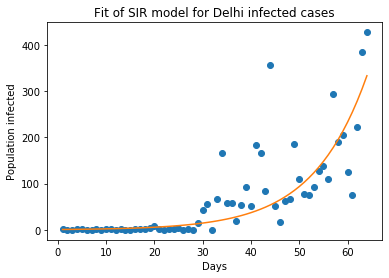

Optimal parameters: beta = 4.61553835278881  and gamma =  4.522649444889439


In [7]:
no_predict=9
ydata=df_delhi.ConfirmedCasesPD.values[:-no_predict-1]
y_pred_data=df_delhi.ConfirmedCasesPD.values[-no_predict:]
xdata=[i for i in range(1,ydata.shape[0]+1)]
xdata=np.array(xdata, dtype=float)
N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for Delhi infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

In [8]:
li_pred=[]
for j in ydata:
    for i in range(10):
        li_pred.append(j)
        

for j in y_pred_data:
    for i in range(10):
        li_pred.append(j)


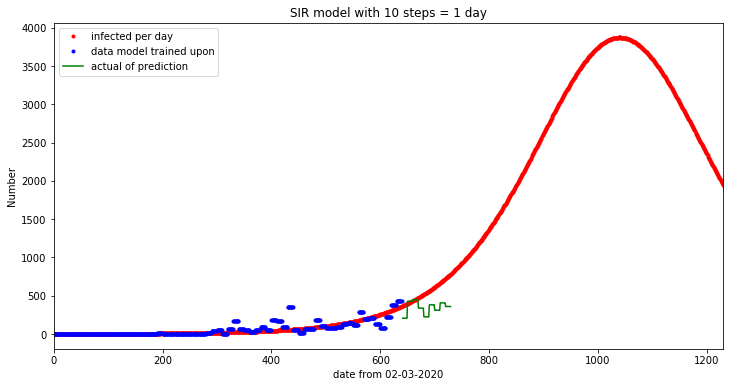

In [9]:
N = 19000000
b0 = 0
beta = popt[0]
gamma = popt[1]
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)
inf=[i*N for i in inf ]
rec=[i*N for i in rec ]
lim=len(li_pred)+500
xdata=range(lim)
 
f = plt.figure(figsize=(12,6)) 
#plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected per day');
#plt.plot(rec, 'c.', label='recovered/deceased');
plt.plot(xdata[:(len(ydata))*10],li_pred[:(len(ydata))*10], 'b.', label='data model trained upon');
plt.plot(xdata[((len(ydata))*10)+1:len(li_pred)],li_pred[(((len(ydata))*10)+1):], 'g', label='actual of prediction');
plt.title("SIR model with 10 steps = 1 day")
plt.xlabel("date from 02-03-2020", fontsize=10);
plt.ylabel("Number", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,lim)
plt.savefig('SIR_example.png')
plt.show()

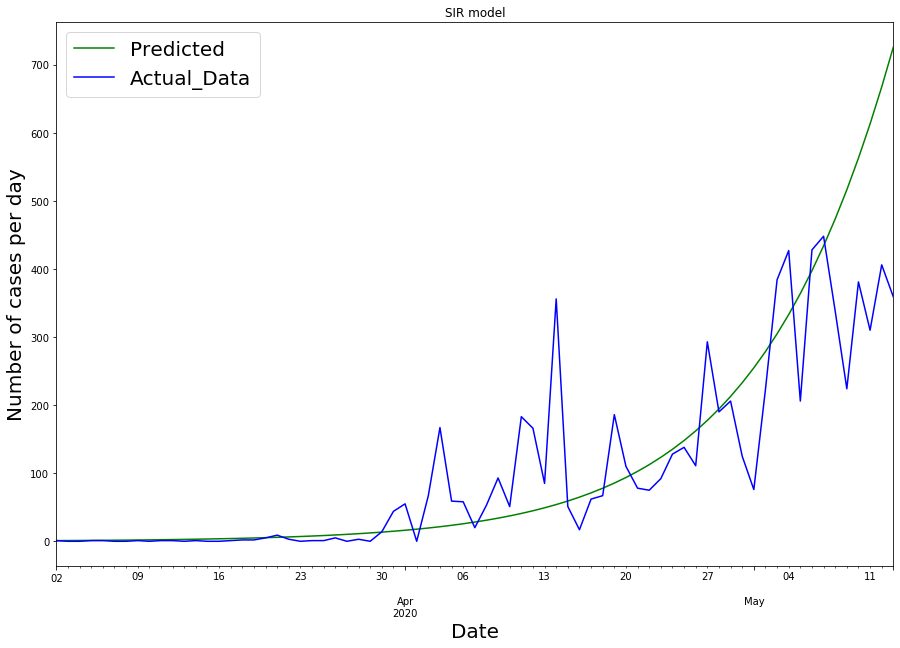

In [10]:
li_temp=[]
li_temp1=[]
for i in range(0,len(li_pred),10):
    li_temp.append(inf[i])
    li_temp1.append(li_pred[i])
    
li_dates=df_delhi.index.values
li_dates=li_dates[:-1]
df_combined = pd.DataFrame({'Actual_Data': li_temp1,
                   'Predicted': li_temp,"Date":li_dates})
df_combined['Date'] = pd.to_datetime(df_combined['Date'])
df_combined.set_index('Date', inplace=True)
fig, ax1 = plt.subplots(figsize=(15, 10))
df_combined['Predicted'].plot(kind='line', color='g')
df_combined['Actual_Data'].plot(kind='line', color='b')
plt.legend(loc='best', fontsize=20)
plt.title("SIR model")
plt.xlabel("Date", fontsize=20);
plt.ylabel("Number of cases per day", fontsize=20);


In [11]:
date=[]
date.append(datetime.date(2020, 3, 2))

for i in range(len(li_pred),len(li_pred)+110,10):
    li_temp1.append(-1)
    li_temp.append(inf[i])
    
for i in range(len(li_temp)-1):
    date.append(date[-1]+datetime.timedelta(days=1))

dic={'Actual_Data': li_temp1,
                  'Predicted': li_temp,"Date":date}


(0, 1788.6401565357944)

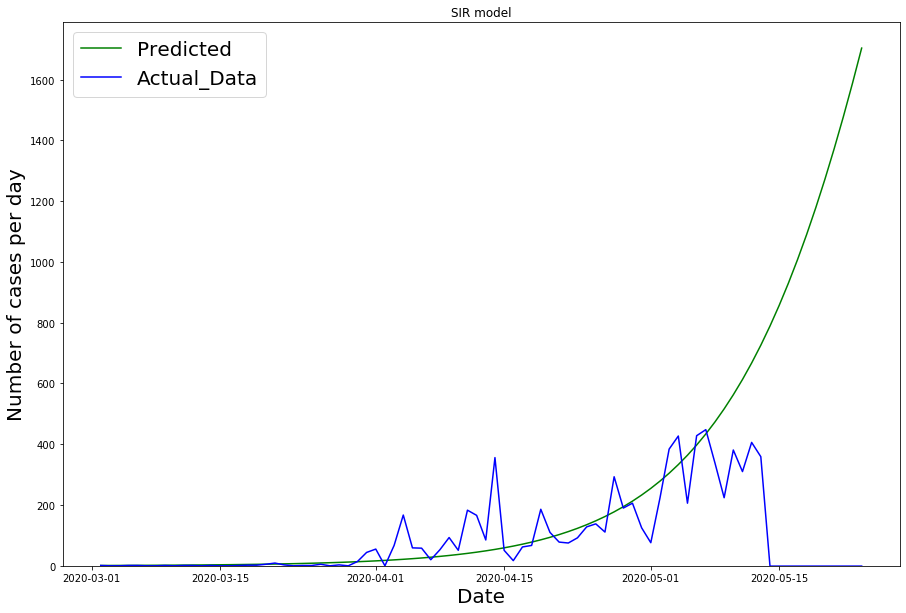

In [12]:
df_combined2=pd.DataFrame(dic)
df_combined2.set_index('Date', inplace=True)
fig, ax1 = plt.subplots(figsize=(15, 10))
df_combined2['Predicted'].plot(kind='line', color='g')
df_combined2['Actual_Data'].plot(kind='line', color='b')
plt.legend(loc='best', fontsize=20)
plt.title("SIR model")
plt.xlabel("Date", fontsize=20);
plt.ylabel("Number of cases per day", fontsize=20)
plt.ylim(0)

In [13]:
total=sum(li_pred[(((len(ydata))*10)+1):])

sum_inf=0
for i in range(((len(ydata))*10),len(li_pred)):
    sum_inf+=inf[i]
    
error=(sum_inf-total)

error=math.sqrt(((error/total)*100)**2)
print("Error in prediction of last 9 days is  ; %.2f" % error,"pct")

Error in prediction of last 9 days is  ; 60.49 pct


In [14]:
df_MH=df.loc[df.State=="Maharashtra"]
df_MH["ConfirmedCasesPD"]=df_MH.ConfirmedCases.diff().fillna(0)
df_MH.iloc[[0],[-1]]=2
df_MH.head()

,State,Indian_National,Foreign_National,Cured,Latitude,Longitude,Death,ConfirmedCases,ConfirmedCasesPD
Date,,,,,,,,,
2020-03-09,Maharashtra,2,0,0,19.7515,75.7139,0,2,2.0
2020-03-10,Maharashtra,5,0,0,19.7515,75.7139,0,5,3.0
2020-03-11,Maharashtra,10,0,0,19.7515,75.7139,0,10,5.0
2020-03-12,Maharashtra,11,0,0,19.7515,75.7139,0,11,1.0
2020-03-13,Maharashtra,11,0,0,19.7515,75.7139,0,11,0.0


In [15]:
population=114200000

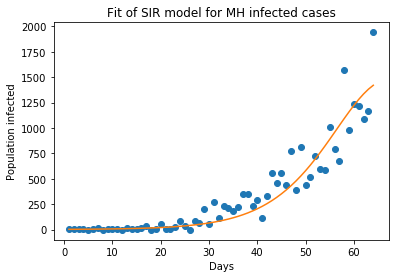

Optimal parameters: beta = 23.685028784927255  and gamma =  23.564647749503354


In [16]:
no_predict=2
ydata=df_MH.ConfirmedCasesPD.values[:-no_predict-1]
y_pred_data=df_MH.ConfirmedCasesPD.values[-no_predict:]
xdata=[i for i in range(1,ydata.shape[0]+1)]
xdata=np.array(xdata, dtype=float)
N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for MH infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

In [17]:
li_pred=[]
for j in ydata:
    for i in range(10):
        li_pred.append(j)
        

for j in y_pred_data:
    for i in range(10):
        li_pred.append(j)


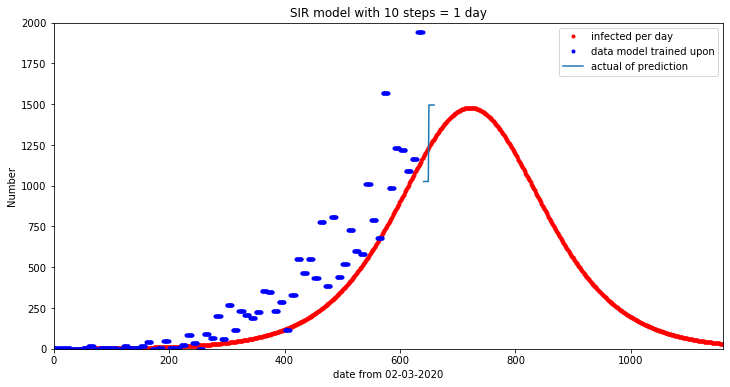

In [18]:
N = 114200000
b0 = 0
beta = popt[0]
gamma = popt[1]
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)
inf=[i*N for i in inf ]
rec=[i*N for i in rec ]
lim=len(li_pred)+500
xdata=range(lim)
 
f = plt.figure(figsize=(12,6)) 
#plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected per day');
#plt.plot(rec, 'c.', label='recovered/deceased');
plt.plot(xdata[:(len(ydata))*10],li_pred[:(len(ydata))*10], 'b.', label='data model trained upon');
plt.plot(xdata[((len(ydata))*10)+1:len(li_pred)],li_pred[(((len(ydata))*10)+1):], label='actual of prediction');
plt.title("SIR model with 10 steps = 1 day")
plt.xlabel("date from 02-03-2020", fontsize=10);
plt.ylabel("Number", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,lim)
plt.ylim(0,2000)
plt.savefig('SIR_example.png')
plt.show()

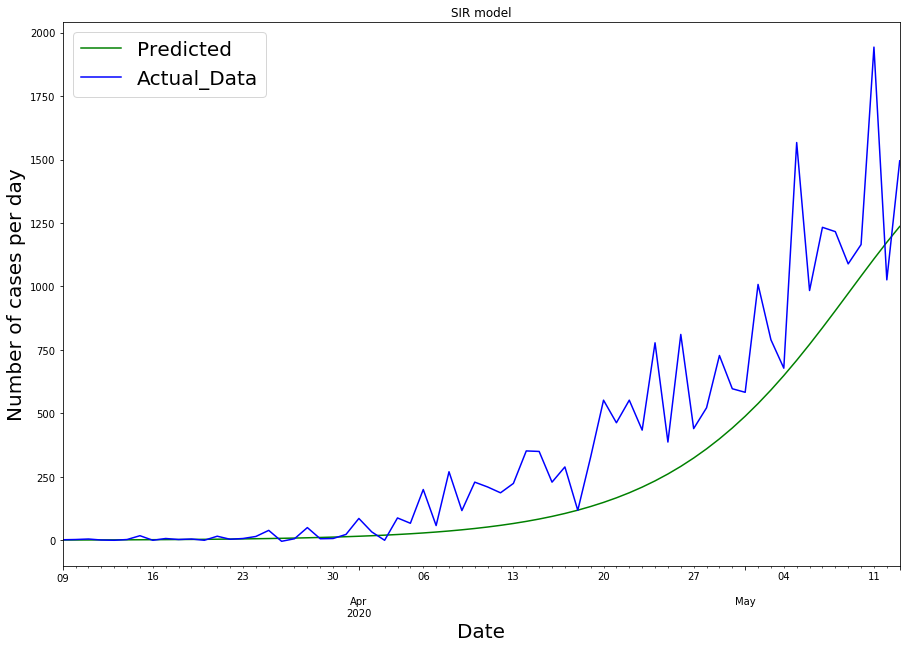

In [19]:
li_temp=[]
li_temp1=[]
for i in range(0,len(li_pred),10):
    li_temp.append(inf[i])
    li_temp1.append(li_pred[i])
    
li_dates=df_MH.index.values
li_dates=li_dates[:-1]
df_combined = pd.DataFrame({'Actual_Data': li_temp1,
                   'Predicted': li_temp,"Date":li_dates})
df_combined['Date'] = pd.to_datetime(df_combined['Date'])
df_combined.set_index('Date', inplace=True)
fig, ax1 = plt.subplots(figsize=(15, 10))
df_combined['Predicted'].plot(kind='line', color='g')
df_combined['Actual_Data'].plot(kind='line', color='b')
plt.legend(loc='best', fontsize=20)
plt.title("SIR model")
plt.xlabel("Date", fontsize=20);
plt.ylabel("Number of cases per day", fontsize=20);